<a href="https://colab.research.google.com/github/harraznasrullah/traffic_light_deteection_system/blob/main/traffic_light_detection_yolov8large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Traffic Light Detection using YOLOv8**

In [1]:
"""
For cloud environments.
"""
!pip install matplotlib
!pip install pycocotools
!pip uninstall opencv-python -y
!pip uninstall opencv-python-headless -y
!pip install opencv-python-headless

Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)


In [2]:
!pip install keras-cv==0.5.1

In [3]:
!pip install keras-core

## Imports

In [17]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv
import requests
import zipfile

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization

## Download Dataset

In [2]:
# Download dataset.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f"Downloading file")
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size,
            unit='iB',
            unit_scale=True
        )
        with open(os.path.join(save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print('File already present')

download_file(
    'https://www.dropbox.com/scl/fi/suext2oyjxa0v4p78bj3o/S2TLD_720x1280.zip?rlkey=iequuynn54uib0uhsc7eqfci4&dl=1',
    'S2TLD_720x1280.zip'
)

File already present


In [3]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('S2TLD_720x1280.zip')

Extracted all


## Dataset and Training Parameters

In [4]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
EPOCH = 75
GLOBAL_CLIPNORM = 10.0
IMG_SIZE = (640, 640)

## Dataset Preparation

In [5]:
class_ids = [
    "red",
    "yellow",
    "green",
    "off",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "S2TLD_720x1280/images/"
path_annot = "S2TLD_720x1280/annotations/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [6]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/4564 [00:00<?, ?it/s]

In [7]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [8]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [19]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


import tensorflow as tf

def load_dataset(image_path, classes, bbox):
    """
    Load an image and its associated bounding boxes.

    Args:
        image_path (str): Path to the image.
        classes (list): List of class indices for the bounding boxes.
        bbox (list): List of bounding box coordinates in the format [x_min, y_min, x_max, y_max].

    Returns:
        dict: A dictionary containing the image tensor and bounding boxes.
    """
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize image if necessary (adjust size as needed)

    # Normalize bounding box coordinates to match the resized image
    image_height, image_width = tf.shape(image)[0], tf.shape(image)[1]
    bbox = tf.convert_to_tensor(bbox, dtype=tf.float32)

    # Ensure bounding box coordinates are scaled between 0 and 1
    normalized_boxes = tf.stack([
        bbox[:, 0] / image_width,  # x_min
        bbox[:, 1] / image_height,  # y_min
        bbox[:, 2] / image_width,  # x_max
        bbox[:, 3] / image_height   # y_max
    ], axis=-1)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": normalized_boxes,
    }

    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [15]:
!pip install --upgrade tensorflow keras-cv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 66.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
  Attempting uninstall: keras-cv
    Found existing installation: keras-cv 0.5.1
    Uninstalling keras-cv-0.5.1:
      Successfully uninstalled keras-cv-0.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires opencv-python>=3.4.8.29, which is not installed.
tf-ke

In [10]:
import keras_cv
print(keras_cv.__version__)

0.9.0


In [11]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomGaussianBlur(kernel_size=(3, 3), factor=(0.5, 0.5)),
        keras_cv.layers.RandomBrightness(factor=(0.5, 0.5)),
        keras_cv.layers.RandomContrast(value_range=(0, 255), factor=(0.1, 0.9)),
        keras_cv.layers.JitteredResize(
            target_size=IMG_SIZE,
            scale_factor=(0.75, 1.3),
            bounding_box_format="xyxy",
        ),
    ]
)

In [12]:
# prompt: i dont want to use keras_cv is there any other  option
# augmenter = keras.Sequential(
#     layers=[
#         keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
#         # keras_cv.layers.RandomGaussianBlur(kernel_size=(3, 3), factor=(0.5, 0.5)),
#         # keras_cv.layers.RandomBrightness(factor=(0.5, 0.5)),
#         # keras_cv.layers.RandomContrast(value_range=(0, 255), factor=(0.1, 0.9)),
#         keras_cv.layers.JitteredResize(
#             target_size=IMG_SIZE,
#             scale_factor=(0.75, 1.3),
#             bounding_box_format="xyxy",
#         ),
#     ]
# )

import tensorflow as tf
from tensorflow import keras

# Assuming IMG_SIZE is defined elsewhere in your code
IMG_SIZE = (640, 640)

augmenter = keras.Sequential(
    layers=[
        keras.layers.RandomFlip(mode="horizontal"),
        # keras.layers.RandomGaussianBlur(...),  # Requires further parameter specification
        # keras.layers.RandomBrightness(...),   # Requires further parameter specification
        # keras.layers.RandomContrast(...),     # Requires further parameter specification
        keras.layers.Resizing(height=IMG_SIZE[0], width=IMG_SIZE[1])
    ]
)

In [13]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

# prompt: Arguments received by RandomFlip.call():
#   • inputs={'images': 'tf.Tensor(shape=(8, None, None, 3), dtype=float32)', 'bounding_boxes': {'classes': 'tf.Tensor(shape=(8, None), dtype=float32)', 'boxes': 'tf.Tensor(shape=(8, None, None), dtype=float32)'}}
#   • training=True

import tensorflow as tf

def random_flip_bounding_boxes(inputs, training):
  """Applies random horizontal flip to images and bounding boxes.

  Args:
    inputs: A dictionary containing 'images' and 'bounding_boxes'.
    training: A boolean indicating whether the model is in training mode.

  Returns:
    A dictionary with the flipped images and bounding boxes.
  """
  if not training:
      return inputs

  images = inputs['images']
  bounding_boxes = inputs['bounding_boxes']

  # Flip images horizontally
  flipped_images = tf.image.flip_left_right(images)

  # Get bounding box information
  boxes = bounding_boxes['boxes']
  classes = bounding_boxes['classes']

  # Calculate image width
  image_width = tf.cast(tf.shape(images)[2], tf.float32)

  # Flip the bounding box coordinates
  flipped_boxes = tf.stack([
      image_width - boxes[..., 2],  # xmin
      boxes[..., 1],               # ymin
      image_width - boxes[..., 0],  # xmax
      boxes[..., 3]                # ymax
  ], axis=-1)

  return {
      'images': flipped_images,
      'bounding_boxes': {
          'classes': classes,
          'boxes': flipped_boxes
      }
  }

In [14]:
resizing = keras_cv.layers.JitteredResize(
    target_size=IMG_SIZE,
    scale_factor=(1.0, 1.0),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
# prompt: resizing = keras_cv.layers.JitteredResize(
#     target_size=IMG_SIZE,
#     scale_factor=(1.0, 1.0),
#     bounding_box_format="xyxy",
# )
# val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.shuffle(BATCH_SIZE * 4)
# val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
# val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE), NameError: name 'keras_cv' is not defined , i dont want keras_cv suggest me different modules

import tensorflow as tf
from tensorflow import keras

# Assuming IMG_SIZE is defined elsewhere in your code
IMG_SIZE = (640, 640)

resizing = keras.layers.Resizing(height=IMG_SIZE[0], width=IMG_SIZE[1])

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(lambda x: {**x, 'images': resizing(x['images'])}, num_parallel_calls=tf.data.AUTOTUNE)

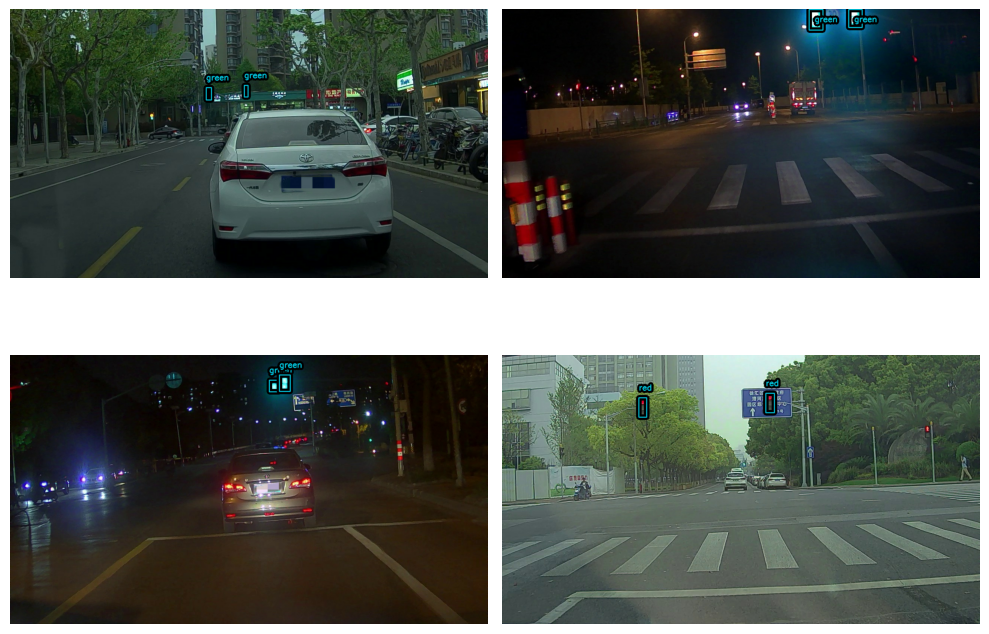

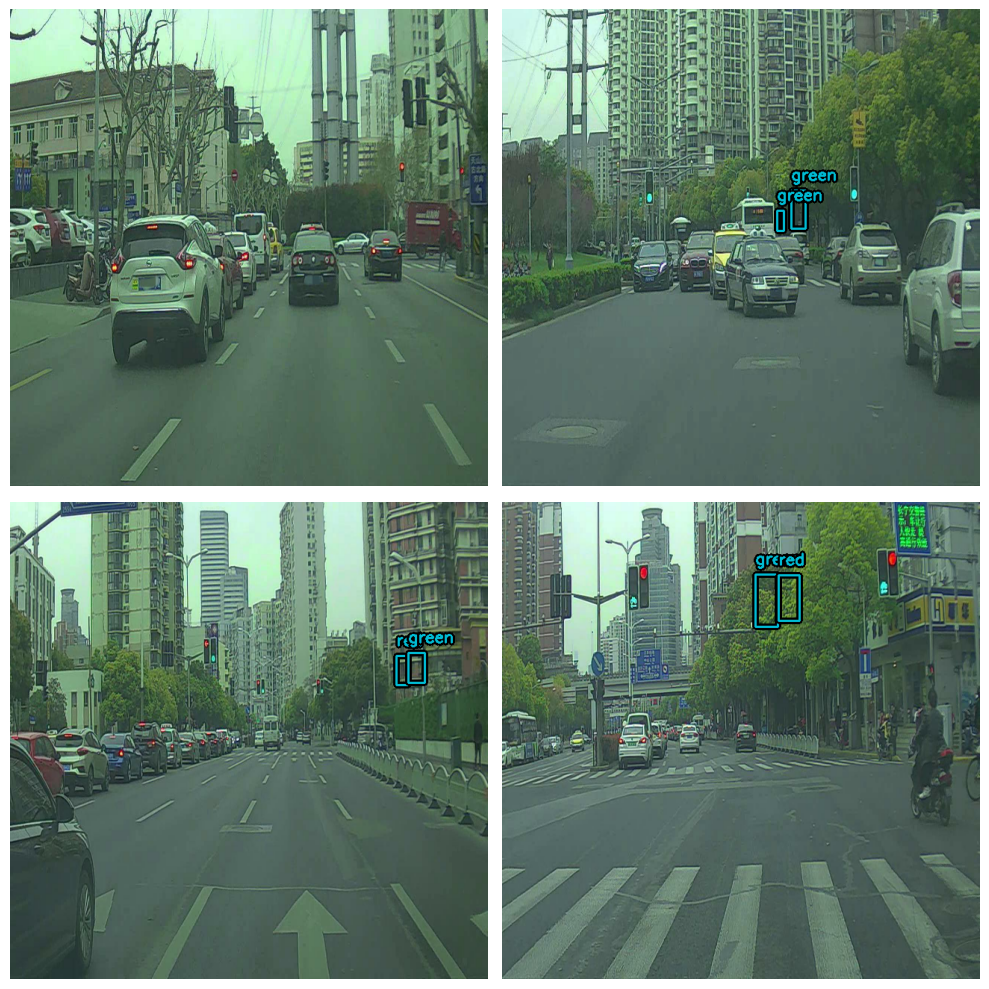

In [20]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
# prompt: i dont want keras_cv

import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import requests
import zipfile
from tqdm.auto import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.patches as patches


!pip install matplotlib
!pip install pycocotools
!pip uninstall opencv-python -y
!pip uninstall opencv-python-headless -y
!pip install opencv-python-headless
!pip install keras-core
!pip install matplotlib.py

# ## Imports

# from keras_cv import bounding_box
# from keras_cv import visualization
# ## Download Dataset
# Download dataset.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f"Downloading file")
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size,
            unit='iB',
            unit_scale=True
        )
        with open(os.path.join(save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print('File already present')

download_file(
    'https://www.dropbox.com/scl/fi/suext2oyjxa0v4p78bj3o/S2TLD_720x1280.zip?rlkey=iequuynn54uib0uhsc7eqfci4&dl=1',
    'S2TLD_720x1280.zip'
)
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('S2TLD_720x1280.zip')
# ## Dataset and Training Parameters
SPLIT_RATIO = 0.2
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
EPOCH = 75
GLOBAL_CLIPNORM = 10.0
IMG_SIZE = (640, 640)
# ## Dataset Preparation
class_ids = [
    "red",
    "yellow",
    "green",
    "off",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "S2TLD_720x1280/images/"
path_annot = "S2TLD_720x1280/annotations/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

augmenter = keras.Sequential(
    layers=[
        keras.layers.RandomFlip(mode="horizontal"),
        keras.layers.Resizing(height=IMG_SIZE[0], width=IMG_SIZE[1])
    ]
)
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)



def random_flip_bounding_boxes(inputs, training):
  """Applies random horizontal flip to images and bounding boxes.

  Args:
    inputs: A dictionary containing 'images' and 'bounding_boxes'.
    training: A boolean indicating whether the model is in training mode.

  Returns:
    A dictionary with the flipped images and bounding boxes.
  """
  if not training:
      return inputs

  images = inputs['images']
  bounding_boxes = inputs['bounding_boxes']

  # Flip images horizontally
  flipped_images = tf.image.flip_left_right(images)

  # Get bounding box information
  boxes = bounding_boxes['boxes']
  classes = bounding_boxes['classes']

  # Calculate image width
  image_width = tf.cast(tf.shape(images)[2], tf.float32)

  # Flip the bounding box coordinates
  flipped_boxes = tf.stack([
      image_width - boxes[..., 2],  # xmin
      boxes[..., 1],               # ymin
      image_width - boxes[..., 0],  # xmax
      boxes[..., 3]                # ymax
  ], axis=-1)

  return {
      'images': flipped_images,
      'bounding_boxes': {
          'classes': classes,
          'boxes': flipped_boxes
      }
  }

resizing = keras.layers.Resizing(height=IMG_SIZE[0], width=IMG_SIZE[1])

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(lambda x: {**x, 'images': resizing(x['images'])}, num_parallel_calls=tf.data.AUTOTUNE)



def visualize_dataset(dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    for i, sample in enumerate(dataset.take(rows * cols)):
        ax = axes[i // cols, i % cols]
        image = sample['images'][0].numpy()  # Assuming batch dimension
        boxes = sample['bounding_boxes']['boxes'][0].numpy()  # Assuming batch dimension
        classes = sample['bounding_boxes']['classes'][0].numpy()

        # Scale image if necessary
        if value_range == (0, 255):
            image = image / 255.0
        ax.imshow(image)

        # Draw bounding boxes
        for box, cls in zip(boxes, classes):
            if bounding_box_format == "xyxy":
                xmin, ymin, xmax, ymax = box
                width, height = xmax - xmin, ymax - ymin
            else:
                raise ValueError(f"Unsupported bounding_box_format: {bounding_box_format}")

            rect = patches.Rectangle(
                (xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin, class_mapping[int(cls)], color="blue", fontsize=10)

        ax.axis("off")
    plt.tight_layout()
    plt.show()


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)
visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)





In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## YOLOv8 Model

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco",
    load_weights=True
)

In [ ]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3,
)

In [ ]:
yolo.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

## Evaluation Metrics

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

## Tensorboard Callback

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8large")

## Training

In [ ]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[
        EvaluateCOCOMetricsCallback(val_ds, "model_yolov8large.h5"),
        tensorboard_callback
    ],
)

## Inference on Validation Images using the Trained Model

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    for i in range(10):
        images, y_true = next(iter(dataset.take(i+1)))
        y_pred = model.predict(images)
        y_pred = bounding_box.to_ragged(y_pred)
        visualization.plot_bounding_box_gallery(
            images,
            value_range=(0, 255),
            bounding_box_format=bounding_box_format,
            # y_true=y_true,
            y_pred=y_pred,
            scale=4,
            rows=2,
            cols=2,
            show=True,
            font_scale=0.7,
            class_mapping=class_mapping,
        )
visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")